# Pred Notebook for Kaggle Playground S6E2
This notebook uses insights and the prediction pipeline suggested from the following EDA notebook: [EDA Statistical Insight + Modeling Guidance](https://www.kaggle.com/code/pilkwang/eda-statistical-insight-modeling-guidance).

## Notebook Goal
- Build a reproducible binary-classification pipeline for train/test data.
- Compare models by OOF ROC-AUC and pick the most stable one.

## Core Strategy
- Validation: StratifiedKFold (5 folds)
- Main metric: ROC-AUC
- `original` data usage: fold-level training augmentation (with weight control)


## 0. Imports and Config
This section defines required libraries and global experiment settings.

- `SEED`, `N_SPLITS`: reproducibility and CV structure
- `TARGET`, `TARGET_MAP`: unified label-processing rule
- `CATS`, `NUMS`: feature-type guide reused from EDA


In [1]:
import warnings
warnings.filterwarnings('ignore')

import gc
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Optional model imports
HAS_CATBOOST = True
HAS_LGBM = True
HAS_XGB = True

try:
    from catboost import CatBoostClassifier
except Exception:
    HAS_CATBOOST = False

try:
    from lightgbm import LGBMClassifier
except Exception:
    HAS_LGBM = False

try:
    from xgboost import XGBClassifier
except Exception:
    HAS_XGB = False

# Reproducibility: fixed random seed baseline
SEED = 42
N_SPLITS = 5

# Seed averaging (set multiple seeds to reduce LB shake-up)
SEED_LIST = [42, 2024, 7, 3407, 777]

# Speed / hardware flags
FAST_MODE = False

ON_MAC = platform.system() == 'Darwin'
FORCE_USE_GPU = None
# Hardware routing: auto-disable GPU on macOS by default
USE_GPU = (not ON_MAC) if FORCE_USE_GPU is None else bool(FORCE_USE_GPU)
ENABLE_CPU_FALLBACK = True
LGBM_GPU_SAFE_MODE = False

TARGET = 'Heart Disease'
TARGET_BIN = 'target_bin'
ID_COL = 'id'
TARGET_MAP = {'Absence': 0, 'Presence': 1}

CATS = [
    'Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
    'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'
]
NUMS = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

ORIGINAL_WEIGHT = 0.35

# Memory optimization toggle
ENABLE_DOWNCAST = False


def memory_mb(df):
    return df.memory_usage(deep=True).sum() / (1024 ** 2)


# Memory optimization: optional numeric downcasting
def downcast_dataframe(df):
    """Reduce memory footprint for large tabular data."""
    df_opt = df.copy()

    int_cols = df_opt.select_dtypes(include=['int64', 'int32']).columns
    for col in int_cols:
        df_opt[col] = pd.to_numeric(df_opt[col], downcast='integer')

    float_cols = df_opt.select_dtypes(include=['float64', 'float32']).columns
    for col in float_cols:
        df_opt[col] = pd.to_numeric(df_opt[col], downcast='float')

    return df_opt

print('Model availability:')
print(f'  CatBoost : {HAS_CATBOOST}')
print(f'  LightGBM : {HAS_LGBM}')
print(f'  XGBoost  : {HAS_XGB}')
print('FAST_MODE:', FAST_MODE)
print('ON_MAC:', ON_MAC, '| USE_GPU:', USE_GPU, '| CPU fallback:', ENABLE_CPU_FALLBACK)
print('LGBM_GPU_SAFE_MODE:', LGBM_GPU_SAFE_MODE)
print('SEED_LIST:', SEED_LIST)
print('ENABLE_DOWNCAST:', ENABLE_DOWNCAST)




Model availability:
  CatBoost : True
  LightGBM : True
  XGBoost  : True
FAST_MODE: False
ON_MAC: False | USE_GPU: True | CPU fallback: True
LGBM_GPU_SAFE_MODE: False
SEED_LIST: [42, 2024, 7, 3407, 777]
ENABLE_DOWNCAST: False


## 1. Load Data
Load training/inference files and run minimal schema checks.

- `train.csv`: training data (includes target)
- `test.csv`: inference data (no target)
- `Heart_Disease_Prediction.csv`: optional external augmentation data


In [2]:
# 1) Load main competition files
train = pd.read_csv('/kaggle/input/playground-series-s6e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e2/test.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s6e2/sample_submission.csv')

# 2) Load optional original dataset for data augmentation
try:
    original = pd.read_csv('/kaggle/input/datasets/pilkwang/heart-disease-prediction/Heart_Disease_Prediction.csv')
    HAS_ORIGINAL = True
except FileNotFoundError:
    original = None
    HAS_ORIGINAL = False

print('Before downcast memory (MB):')
print('  train:', round(memory_mb(train), 2))
print('  test :', round(memory_mb(test), 2))
if HAS_ORIGINAL:
    print('  original:', round(memory_mb(original), 2))

# 3) Optional downcast (OFF by default)
# Toggle-based memory optimization (safe to keep OFF)
if ENABLE_DOWNCAST:
    train = downcast_dataframe(train)
    test = downcast_dataframe(test)
    if HAS_ORIGINAL:
        original = downcast_dataframe(original)
    print('Downcast applied.')
else:
    print('Downcast skipped (ENABLE_DOWNCAST=False).')

print('After optional downcast memory (MB):')
print('  train:', round(memory_mb(train), 2))
print('  test :', round(memory_mb(test), 2))
if HAS_ORIGINAL:
    print('  original:', round(memory_mb(original), 2))

print('train:', train.shape)
print('test :', test.shape)
print('sample_submission:', sample_sub.shape)
print('original:', None if original is None else original.shape)

assert TARGET in train.columns, f'Missing target column: {TARGET}'
assert ID_COL in train.columns and ID_COL in test.columns, f'Missing id column: {ID_COL}'



Before downcast memory (MB):
  train: 101.21
  test : 28.84
  original: 0.04
Downcast skipped (ENABLE_DOWNCAST=False).
After optional downcast memory (MB):
  train: 101.21
  test : 28.84
  original: 0.04
train: (630000, 15)
test : (270000, 14)
sample_submission: (270000, 2)
original: (270, 14)


## 2. Preprocessing (Aligned with EDA)
Prepare model inputs using the same rules validated in EDA.

- Convert target labels (`Absence/Presence`) to 0/1
- Keep categorical dtype handling consistent
- Unify category sets across train/test/original to prevent encoding mismatch


In [3]:
# 1) Define predictor columns
feature_cols = [c for c in train.columns if c not in [ID_COL, TARGET, TARGET_BIN]]

# 2) Keep only features that are actually present in this dataset
cats = [c for c in CATS if c in feature_cols]
nums = [c for c in NUMS if c in feature_cols]

# 3) Convert target label to binary target
# Label encoding: convert text target -> binary 0/1
train[TARGET_BIN] = train[TARGET].map(TARGET_MAP)
if train[TARGET_BIN].isna().any():
    bad_labels = train.loc[train[TARGET_BIN].isna(), TARGET].unique().tolist()
    raise ValueError(f'Unmapped target labels in train: {bad_labels}')

# 4) Build model input matrices
X = train[feature_cols].copy()
y = train[TARGET_BIN].astype('int8').copy()
X_test = test[feature_cols].copy()

# 5) Prepare optional external(original) set
X_orig = None
y_orig = None
if HAS_ORIGINAL:
    if TARGET not in original.columns:
        HAS_ORIGINAL = False
    else:
        original[TARGET_BIN] = original[TARGET].map(TARGET_MAP)
        if original[TARGET_BIN].isna().any():
            bad_labels = original.loc[original[TARGET_BIN].isna(), TARGET].unique().tolist()
            raise ValueError(f'Unmapped target labels in original: {bad_labels}')
        X_orig = original[feature_cols].copy()
        y_orig = original[TARGET_BIN].astype('int8').copy()

# 6) Unify categorical levels across train/test/original
frames_for_categories = [X, X_test] + ([X_orig] if X_orig is not None else [])
# Category alignment: prevent train/test code mismatch
for c in cats:
    unified = pd.Index(sorted(set().union(*[set(df[c].dropna().unique()) for df in frames_for_categories])))
    cat_dtype = pd.CategoricalDtype(categories=unified)
    for df in frames_for_categories:
        df[c] = df[c].astype(cat_dtype)

print('feature count:', len(feature_cols))
print('categorical:', cats)
print('numerical  :', nums)
print('target mean (Presence rate):', y.mean())
print('use original:', HAS_ORIGINAL, '| ORIGINAL_WEIGHT =', ORIGINAL_WEIGHT)
if HAS_ORIGINAL:
    print('original target mean:', y_orig.mean(), '| rows:', len(y_orig))



feature count: 13
categorical: ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
numerical  : ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
target mean (Presence rate): 0.44833968253968254
use original: True | ORIGINAL_WEIGHT = 0.35
original target mean: 0.4444444444444444 | rows: 270


## 2.1 Interaction Features (EDA-driven)
This optional section adds interaction features inspired by EDA findings.

- Numeric interactions (e.g., product/difference/ratio)
- Categorical pair interactions (combined category tokens)
- Category alignment across train/test/original


In [4]:
# Turn on/off engineered interactions
USE_INTERACTIONS = True

if USE_INTERACTIONS:
    frames = [X, X_test] + ([X_orig] if X_orig is not None else [])

    # Feature engineering: interaction terms can capture non-linear effects
# Numeric interactions
    for df in frames:
        if all(col in df.columns for col in ['Age', 'ST depression']):
            df['Age_x_STdepression'] = (df['Age'] * df['ST depression']).astype('float32')

        if all(col in df.columns for col in ['Max HR', 'Age']):
            df['MaxHR_minus_Age'] = (df['Max HR'] - df['Age']).astype('float32')

        if all(col in df.columns for col in ['ST depression', 'Max HR']):
            df['STdepression_over_MaxHR'] = (df['ST depression'] / (df['Max HR'] + 1e-3)).astype('float32')

    # Pairwise category features: useful when combinations carry signal
# Categorical pair interactions
    cat_pair_candidates = [
        ('Chest pain type', 'Thallium', 'ChestPain_x_Thallium'),
        ('Exercise angina', 'Slope of ST', 'ExAngina_x_SlopeST'),
    ]

    added_cat_interactions = []
    for c1, c2, new_col in cat_pair_candidates:
        if c1 in X.columns and c2 in X.columns:
            for df in frames:
                df[new_col] = (df[c1].astype(str) + '__' + df[c2].astype(str))
            added_cat_interactions.append(new_col)

    for new_col in added_cat_interactions:
        unified = pd.Index(sorted(set().union(*[set(df[new_col].dropna().unique()) for df in frames])))
        cat_dtype = pd.CategoricalDtype(categories=unified)
        for df in frames:
            df[new_col] = df[new_col].astype(cat_dtype)

    # extra memory optimization after feature engineering
    X = downcast_dataframe(X)
    X_test = downcast_dataframe(X_test)
    if X_orig is not None:
        X_orig = downcast_dataframe(X_orig)

    cats = list(dict.fromkeys(cats + added_cat_interactions))
    feature_cols = X.columns.tolist()

    print('Interaction features enabled.')
    print('Added categorical interactions:', added_cat_interactions)
    print('Total feature count after interactions:', len(feature_cols))
    print('X memory (MB):', round(memory_mb(X), 2), '| X_test memory (MB):', round(memory_mb(X_test), 2))
else:
    print('Interaction features disabled.')



Interaction features enabled.
Added categorical interactions: ['ChestPain_x_Thallium', 'ExAngina_x_SlopeST']
Total feature count after interactions: 18
X memory (MB): 19.83 | X_test memory (MB): 8.5


## 3. CV Helper
Reusable helper functions for model training and evaluation.

- `_encode_categories_consistently`: category-code conversion for non-CatBoost models
- `run_cv`: fold training, OOF prediction, averaged test prediction, ROC-AUC calculation
- `sample_weight`: controls influence of `original` data during augmentation


In [5]:
# Encoding helper: fit category mapping on train-fold only
def _encode_categories_consistently(train_df, valid_df, test_df, extra_df=None):
    tr = train_df.copy()
    va = valid_df.copy()
    te = test_df.copy()
    ex = extra_df.copy() if extra_df is not None else None

    for col in tr.columns:
        if str(tr[col].dtype) == 'category':
            categories = tr[col].cat.categories
            dtype = pd.CategoricalDtype(categories=categories)
            tr[col] = tr[col].astype(dtype).cat.codes
            va[col] = va[col].astype(dtype).cat.codes
            te[col] = te[col].astype(dtype).cat.codes
            if ex is not None:
                ex[col] = ex[col].astype(dtype).cat.codes

    return tr, va, te, ex


def _gpu_error_hint(exc):
    msg = str(exc).lower()
    gpu_tokens = ['cuda', 'gpu', 'opencl', 'metal', 'mps', 'device', 'no supported gpu']
    return any(tok in msg for tok in gpu_tokens)


def _to_cpu_params(model_name, params):
    p = dict(params)
    if model_name == 'xgboost':
        p.pop('device', None)
        if p.get('tree_method') in ['gpu_hist']:
            p['tree_method'] = 'hist'
    if model_name == 'lightgbm' and p.get('device') == 'gpu':
        p['device'] = 'cpu'
    if model_name == 'catboost':
        p.pop('task_type', None)
        p.pop('devices', None)
    return p


# Early stopping: stop when validation score stops improving
def _fit_noncat_with_es(model_name, model, X_tr_num, y_tr, X_va_num, y_va, sample_weight):
    if model_name in ['lightgbm', 'xgboost']:
        try:
            model.fit(
                X_tr_num, y_tr,
                sample_weight=sample_weight,
                eval_set=[(X_va_num, y_va)],
                early_stopping_rounds=50,
                verbose=False
            )
        except TypeError:
            if model_name == 'lightgbm':
                from lightgbm import early_stopping, log_evaluation
                model.fit(
                    X_tr_num, y_tr,
                    sample_weight=sample_weight,
                    eval_set=[(X_va_num, y_va)],
                    callbacks=[early_stopping(50), log_evaluation(0)]
                )
            else:
                model.fit(X_tr_num, y_tr, sample_weight=sample_weight)
    else:
        model.fit(X_tr_num, y_tr, sample_weight=sample_weight)


# Core evaluation loop: Stratified K-Fold + OOF prediction
def run_cv(model_name, model_builder, X, y, X_test, n_splits=5, seed=42,
           X_extra=None, y_extra=None, extra_weight=0.0):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # OOF (Out-Of-Fold): unbiased validation predictions for every train row
    oof = np.zeros(len(X), dtype=float)
    # Test prediction is averaged across folds (reduces variance)
    test_pred = np.zeros(len(X_test), dtype=float)
    fold_scores = []
    cat_cols = [c for c in X.columns if str(X[c].dtype) == 'category']

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), start=1):
        X_tr = X.iloc[tr_idx].copy()
        y_tr = y.iloc[tr_idx].copy()
        X_va = X.iloc[va_idx].copy()
        y_va = y.iloc[va_idx].copy()

        sample_weight = np.ones(len(X_tr), dtype=float)
        if X_extra is not None and y_extra is not None and extra_weight > 0:
            X_tr = pd.concat([X_tr, X_extra], axis=0, ignore_index=True)
            y_tr = pd.concat([y_tr, y_extra], axis=0, ignore_index=True)
            sample_weight = np.concatenate([
                np.ones(len(tr_idx), dtype=float),
                np.full(len(X_extra), float(extra_weight), dtype=float)
            ])

        model = model_builder()

        try:
            if model_name == 'catboost':
                model.fit(
                    X_tr, y_tr,
                    cat_features=cat_cols,
                    sample_weight=sample_weight,
                    eval_set=(X_va, y_va),
                    use_best_model=True,
                    early_stopping_rounds=50,
                    verbose=False
                )
                va_pred = model.predict_proba(X_va)[:, 1]
                te_pred = model.predict_proba(X_test)[:, 1]
            else:
                X_tr_num, X_va_num, X_te_num, _ = _encode_categories_consistently(X_tr, X_va, X_test)
                _fit_noncat_with_es(model_name, model, X_tr_num, y_tr, X_va_num, y_va, sample_weight)
                va_pred = model.predict_proba(X_va_num)[:, 1]
                te_pred = model.predict_proba(X_te_num)[:, 1]

        except Exception as e:
            if ENABLE_CPU_FALLBACK and _gpu_error_hint(e):
                print(f'[Fallback] {model_name} fold {fold}: GPU failed, retrying on CPU. Reason: {e}')
                cpu_params = _to_cpu_params(model_name, model.get_params())
                cpu_model = model.__class__(**cpu_params)

                if model_name == 'catboost':
                    cpu_model.fit(
                        X_tr, y_tr,
                        cat_features=cat_cols,
                        sample_weight=sample_weight,
                        eval_set=(X_va, y_va),
                        use_best_model=True,
                        early_stopping_rounds=50,
                        verbose=False
                    )
                    va_pred = cpu_model.predict_proba(X_va)[:, 1]
                    te_pred = cpu_model.predict_proba(X_test)[:, 1]
                else:
                    X_tr_num, X_va_num, X_te_num, _ = _encode_categories_consistently(X_tr, X_va, X_test)
                    _fit_noncat_with_es(model_name, cpu_model, X_tr_num, y_tr, X_va_num, y_va, sample_weight)
                    va_pred = cpu_model.predict_proba(X_va_num)[:, 1]
                    te_pred = cpu_model.predict_proba(X_te_num)[:, 1]
            else:
                raise

        oof[va_idx] = va_pred
        test_pred += te_pred / n_splits
        fold_auc = roc_auc_score(y_va, va_pred)
        fold_scores.append(fold_auc)
        print(f'Fold {fold} AUC: {fold_auc:.6f}')

        # release fold memory
        del X_tr, y_tr, X_va, y_va
        gc.collect()

    cv_auc = roc_auc_score(y, oof)
    print(f'Overall OOF AUC: {cv_auc:.6f}')

    return {
        'model_name': model_name,
        'fold_scores': fold_scores,
        'cv_auc': cv_auc,
        'oof_pred': oof,
        'test_pred': test_pred,
    }


# Multi-seed wrapper: average predictions across different random seeds
def run_cv_multi_seed(model_name, model_builder, X, y, X_test, seed_list, n_splits=5,
                      X_extra=None, y_extra=None, extra_weight=0.0):
    all_oof = []
    all_test = []
    all_scores = []

    for sd in seed_list:
        print(f'\n[Seed {sd}]')
        res = run_cv(
            model_name=model_name,
            model_builder=model_builder,
            X=X,
            y=y,
            X_test=X_test,
            n_splits=n_splits,
            seed=sd,
            X_extra=X_extra,
            y_extra=y_extra,
            extra_weight=extra_weight,
        )
        all_oof.append(res['oof_pred'])
        all_test.append(res['test_pred'])
        all_scores.append(res['cv_auc'])

    avg_oof = np.mean(np.vstack(all_oof), axis=0)
    avg_test = np.mean(np.vstack(all_test), axis=0)
    avg_auc = roc_auc_score(y, avg_oof)

    return {
        'model_name': model_name,
        'fold_scores': all_scores,
        'cv_auc': avg_auc,
        'seed_auc_mean': float(np.mean(all_scores)),
        'seed_auc_std': float(np.std(all_scores)),
        'oof_pred': avg_oof,
        'test_pred': avg_test,
    }





## 4. Candidate Models
Register available models and evaluate them under the same protocol.

Default policy:
- Use CatBoost/LGBM/XGBoost when available
- Fall back to `hgb` when external packages are not installed


### Model Notes
- `catboost`: strong categorical handling; primary choice for code-like categorical features.
- `lightgbm`: good speed/performance balance; useful challenger model.
- `xgboost`: robust tree-boosting baseline.
- `hgb` (sklearn): dependency-free fallback model.
- Final selection criterion: `OOF ROC-AUC`.


In [6]:
# Toggle models: adjust by environment/time budget
ENABLE_MODELS = {
    'catboost': True,
    'lightgbm': True,
    'xgboost': True,
    'hgb': True
}

# Parameter source mode
# - 'optuna': run tuning and use tuned params/weights
# - 'manual': skip tuning and use MANUAL_* values below
# - 'base': skip tuning and use baseline HPARAMS + ORIGINAL_WEIGHT
# Parameter source switch: optuna / manual / base
PARAM_SOURCE = 'optuna'

# Optional manual tuned values (reuse from a previous successful tuning run)
# Manual mode: paste known-good tuned params for reproducible reruns
MANUAL_TUNED_PARAMS = {
    'catboost': {
        'iterations': 1551,
        'learning_rate': 0.022816739880816207,
        'depth': 4,
        'l2_leaf_reg': 7.766184280392884,
        'random_strength': 0.8803049874792026,
        'bagging_temperature': 0.24407646968955765,
    },
    'lightgbm': {
        'n_estimators': 764,
        'learning_rate': 0.021399549030176226,
        'num_leaves': 146,
        'min_child_samples': 31,
        'subsample': 0.9208787923016158,
        'colsample_bytree': 0.6298202574719083,
        'reg_alpha': 7.6204817861585425,
        'reg_lambda': 0.08916674715636552,
    },
    'xgboost': {
        'n_estimators': 1304,
        'learning_rate': 0.017128044242493735,
        'max_depth': 3,
        'min_child_weight': 16.49376714064185,
        'subsample': 0.8827429375390469,
        'colsample_bytree': 0.8916028672163949,
        'reg_alpha': 0.08738424135626989,
        'reg_lambda': 4.638759594322625e-08,
        'gamma': 1.7923286427213632,
    },
}

MANUAL_TUNED_ORIGINAL_WEIGHT = {
    'catboost': 0.4951769101112702,
    'lightgbm': 0.1987156815341724,
    'xgboost': 0.11586905952512971,
}

# Base hyperparameters
HPARAMS = {
    'catboost': {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': 900 if FAST_MODE else 1200,
        'learning_rate': 0.03,
        'depth': 6,
        'random_seed': SEED,
        'verbose': False
    },
    'lightgbm': {
        'n_estimators': 700 if FAST_MODE else 900,
        'learning_rate': 0.03,
        'num_leaves': 64,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'random_state': SEED,
        'verbosity': -1,
        'n_jobs': -1,
        'device': 'cpu'
    },
    'xgboost': {
        'n_estimators': 700 if FAST_MODE else 900,
        'learning_rate': 0.03,
        'max_depth': 6,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'eval_metric': 'auc',
        'random_state': SEED,
        'n_jobs': -1,
        'tree_method': 'hist'
    },
    'hgb': {
        'learning_rate': 0.05,
        'max_depth': 6,
        'max_iter': 180 if FAST_MODE else 220,
        'random_state': SEED
    }
}

# GPU params:
# - XGBoost/CatBoost: apply when USE_GPU=True
# - LightGBM: keep CPU by default in SAFE_MODE due to frequent Kaggle GPU-build mismatch
if USE_GPU:
    HPARAMS['xgboost'].update({'tree_method': 'hist', 'device': 'cuda'})
    HPARAMS['catboost'].update({'task_type': 'GPU'})
    if not LGBM_GPU_SAFE_MODE:
        HPARAMS['lightgbm'].update({'device': 'gpu'})
    else:
        HPARAMS['lightgbm'].update({'device': 'cpu'})

print('Hyperparameters ready.')
print('PARAM_SOURCE:', PARAM_SOURCE)
print('LightGBM device:', HPARAMS['lightgbm'].get('device'))
HPARAMS



Hyperparameters ready.
PARAM_SOURCE: optuna
LightGBM device: gpu


{'catboost': {'loss_function': 'Logloss',
  'eval_metric': 'AUC',
  'iterations': 1200,
  'learning_rate': 0.03,
  'depth': 6,
  'random_seed': 42,
  'verbose': False,
  'task_type': 'GPU'},
 'lightgbm': {'n_estimators': 900,
  'learning_rate': 0.03,
  'num_leaves': 64,
  'subsample': 0.9,
  'colsample_bytree': 0.9,
  'random_state': 42,
  'verbosity': -1,
  'n_jobs': -1,
  'device': 'gpu'},
 'xgboost': {'n_estimators': 900,
  'learning_rate': 0.03,
  'max_depth': 6,
  'subsample': 0.9,
  'colsample_bytree': 0.9,
  'eval_metric': 'auc',
  'random_state': 42,
  'n_jobs': -1,
  'tree_method': 'hist',
  'device': 'cuda'},
 'hgb': {'learning_rate': 0.05,
  'max_depth': 6,
  'max_iter': 220,
  'random_state': 42}}

### Optional: Optuna Tuning
Use this section to tune key hyperparameters before the final training run.

How to use:
- Set `RUN_TUNING = True`
- Choose `TUNING_MODELS` and `TUNE_N_TRIALS`
- Run this section, then run the model-registry cell again

Notes:
- Tuning can be expensive on full data, so subsampling is enabled by default.
- Tuned values are merged into `HPARAMS` through `TUNED_PARAMS`.


In [7]:
# Optuna is optional; notebook still works without it.
try:
    import optuna
    HAS_OPTUNA = True
except Exception:
    HAS_OPTUNA = False

# Tuning configuration
# Optuna search toggle (auto from PARAM_SOURCE)
RUN_TUNING = (PARAM_SOURCE == 'optuna')
TUNING_MODELS = ['catboost', 'lightgbm', 'xgboost']
TUNE_N_TRIALS = 10 if FAST_MODE else 25
TUNE_N_SPLITS = 2 if FAST_MODE else 3
TUNE_MAX_ROWS = 60000 if FAST_MODE else 120000
USE_ORIGINAL_IN_TUNING = True

# Keep training rounds fixed and focus search on learning-rate-centric tuning
# Efficient search idea: tune learning_rate first, keep rounds fixed
TUNE_LR_ONLY = True

TUNE_ORIGINAL_WEIGHT = True
ORIGINAL_WEIGHT_MIN = 0.0
ORIGINAL_WEIGHT_MAX = 1.0

print('Optuna available:', HAS_OPTUNA)
print('PARAM_SOURCE:', PARAM_SOURCE, '| RUN_TUNING:', RUN_TUNING)


def _stratified_subsample(X_df, y_sr, max_rows, seed=42):
    if max_rows is None or len(X_df) <= max_rows:
        return X_df, y_sr

    rng = np.random.RandomState(seed)
    y_arr = y_sr.values
    idx_pos = np.where(y_arr == 1)[0]
    idx_neg = np.where(y_arr == 0)[0]

    pos_ratio = len(idx_pos) / len(y_arr)
    n_pos = max(1, int(round(max_rows * pos_ratio)))
    n_neg = max_rows - n_pos

    n_pos = min(n_pos, len(idx_pos))
    n_neg = min(n_neg, len(idx_neg))

    chosen = np.concatenate([
        rng.choice(idx_pos, size=n_pos, replace=False),
        rng.choice(idx_neg, size=n_neg, replace=False)
    ])
    rng.shuffle(chosen)
    return X_df.iloc[chosen].copy(), y_sr.iloc[chosen].copy()


def _suggest_params(trial, model_name):
    if TUNE_LR_ONLY:
        # Keep n_estimators/iterations fixed in HPARAMS and tune learning rate only.
        return {'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.12, log=True)}

    if model_name == 'catboost':
        return {
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.12, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 20.0, log=True),
        }
    if model_name == 'lightgbm':
        return {
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.12, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 16, 256),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 160),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'verbosity': -1,
        }
    if model_name == 'xgboost':
        return {
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.12, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 20.0),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        }
    if model_name == 'hgb':
        return {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
        }
    raise ValueError(f'Unsupported model for tuning: {model_name}')


def _build_model(model_name, params):
    if model_name == 'catboost':
        return CatBoostClassifier(**params)
    if model_name == 'lightgbm':
        return LGBMClassifier(**params)
    if model_name == 'xgboost':
        return XGBClassifier(**params)
    if model_name == 'hgb':
        return HistGradientBoostingClassifier(**params)
    raise ValueError(model_name)


def _is_model_available(model_name):
    if model_name == 'catboost':
        return HAS_CATBOOST and ENABLE_MODELS.get('catboost', True)
    if model_name == 'lightgbm':
        return HAS_LGBM and ENABLE_MODELS.get('lightgbm', True)
    if model_name == 'xgboost':
        return HAS_XGB and ENABLE_MODELS.get('xgboost', True)
    if model_name == 'hgb':
        return ENABLE_MODELS.get('hgb', True)
    return False


TUNED_PARAMS = {}
TUNED_ORIGINAL_WEIGHT = {}

if RUN_TUNING:
    if not HAS_OPTUNA:
        raise RuntimeError('Optuna is not installed. Install optuna or set RUN_TUNING=False.')

    X_tune, y_tune = _stratified_subsample(X, y, TUNE_MAX_ROWS, seed=SEED)
    print(f'Tuning rows: {len(X_tune):,} / {len(X):,}')

    X_orig_tune, y_orig_tune = None, None
    if USE_ORIGINAL_IN_TUNING and HAS_ORIGINAL and X_orig is not None and y_orig is not None:
        X_orig_tune, y_orig_tune = X_orig, y_orig

    for model_name in TUNING_MODELS:
        if not _is_model_available(model_name):
            print(f'Skip tuning: {model_name} (not available or disabled)')
            continue

        print() 
        print('#' * 70)
        print(f'Optuna tuning: {model_name}')
        print('#' * 70)

        base_params = dict(HPARAMS.get(model_name, {}))

        def objective(trial):
            trial_params = _suggest_params(trial, model_name)
            trial_weight = ORIGINAL_WEIGHT
            if X_orig_tune is not None and TUNE_ORIGINAL_WEIGHT:
                trial_weight = trial.suggest_float('original_weight', ORIGINAL_WEIGHT_MIN, ORIGINAL_WEIGHT_MAX)

            merged = {**base_params, **trial_params}
            builder = lambda: _build_model(model_name, merged)

            res = run_cv(
                model_name=model_name,
                model_builder=builder,
                X=X_tune,
                y=y_tune,
                X_test=X_test,
                n_splits=TUNE_N_SPLITS,
                seed=SEED,
                X_extra=X_orig_tune,
                y_extra=y_orig_tune,
                extra_weight=trial_weight if X_orig_tune is not None else 0.0,
            )
            return res['cv_auc']

        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=SEED),
            # Pruner: early terminate weak trials to save time
pruner=optuna.pruners.MedianPruner()
        )
        study.optimize(objective, n_trials=TUNE_N_TRIALS, show_progress_bar=False)

        best_params = dict(study.best_params)
        best_weight = best_params.pop('original_weight', ORIGINAL_WEIGHT)

        TUNED_PARAMS[model_name] = best_params
        TUNED_ORIGINAL_WEIGHT[model_name] = best_weight

        print(f'Best AUC ({model_name}): {study.best_value:.6f}')
        print('Best model params:', best_params)
        print(f'Best original_weight: {best_weight:.4f}')
else:
    print('Tuning skipped. Using baseline HPARAMS and ORIGINAL_WEIGHT.')

print('TUNED_PARAMS:', TUNED_PARAMS)
print('TUNED_ORIGINAL_WEIGHT:', TUNED_ORIGINAL_WEIGHT)



[I 2026-02-17 00:20:19,369] A new study created in memory with name: no-name-c4c184f8-b3a7-455b-880a-2aee1aa79dae


Optuna available: True
PARAM_SOURCE: optuna | RUN_TUNING: True
Tuning rows: 120,000 / 630,000

######################################################################
Optuna tuning: catboost
######################################################################


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953928


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953773


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:21:43,559] Trial 0 finished with value: 0.9539115981339905 and parameters: {'learning_rate': 0.016440479761182902, 'original_weight': 0.9507143064099162}. Best is trial 0 with value: 0.9539115981339905.


Fold 3 AUC: 0.954043
Overall OOF AUC: 0.953912


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.954005


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953803


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:22:28,762] Trial 1 finished with value: 0.953957972033352 and parameters: {'learning_rate': 0.05120074399024334, 'original_weight': 0.5986584841970366}. Best is trial 1 with value: 0.953957972033352.


Fold 3 AUC: 0.954078
Overall OOF AUC: 0.953958


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953511


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953397


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:23:52,950] Trial 2 finished with value: 0.9535406298222493 and parameters: {'learning_rate': 0.008209348372164488, 'original_weight': 0.15599452033620265}. Best is trial 1 with value: 0.953957972033352.


Fold 3 AUC: 0.953729
Overall OOF AUC: 0.953541


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953377


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953235


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:25:15,428] Trial 3 finished with value: 0.9533962958196206 and parameters: {'learning_rate': 0.006013643224015267, 'original_weight': 0.8661761457749352}. Best is trial 1 with value: 0.953957972033352.


Fold 3 AUC: 0.953597
Overall OOF AUC: 0.953396


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953969


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953766


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:26:09,963] Trial 4 finished with value: 0.9539630026765602 and parameters: {'learning_rate': 0.03377813764524288, 'original_weight': 0.7080725777960455}. Best is trial 4 with value: 0.9539630026765602.


Fold 3 AUC: 0.954161
Overall OOF AUC: 0.953963


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953327


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953161


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:27:32,615] Trial 5 finished with value: 0.9533279160500366 and parameters: {'learning_rate': 0.005338029318481386, 'original_weight': 0.9699098521619943}. Best is trial 4 with value: 0.9539630026765602.


Fold 3 AUC: 0.953515
Overall OOF AUC: 0.953328


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953955


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953752


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:28:07,908] Trial 6 finished with value: 0.9539385558900724 and parameters: {'learning_rate': 0.0704557910328643, 'original_weight': 0.21233911067827616}. Best is trial 4 with value: 0.9539630026765602.


Fold 3 AUC: 0.954116
Overall OOF AUC: 0.953939


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953550


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953440


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:29:31,384] Trial 7 finished with value: 0.9535838570777289 and parameters: {'learning_rate': 0.00891100870862594, 'original_weight': 0.18340450985343382}. Best is trial 4 with value: 0.9539630026765602.


Fold 3 AUC: 0.953776
Overall OOF AUC: 0.953584


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953832


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953679


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:30:54,969] Trial 8 finished with value: 0.9538318086567135 and parameters: {'learning_rate': 0.01314887413732941, 'original_weight': 0.5247564316322378}. Best is trial 4 with value: 0.9539630026765602.


Fold 3 AUC: 0.953991
Overall OOF AUC: 0.953832


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953961


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953791


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:32:17,280] Trial 9 finished with value: 0.953942900038742 and parameters: {'learning_rate': 0.01973083091477693, 'original_weight': 0.2912291401980419}. Best is trial 4 with value: 0.9539630026765602.


Fold 3 AUC: 0.954086
Overall OOF AUC: 0.953943


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.954010


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953825


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:33:09,180] Trial 10 finished with value: 0.9539815143036209 and parameters: {'learning_rate': 0.037409779552594155, 'original_weight': 0.7171409693086566}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954116
Overall OOF AUC: 0.953982


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953960


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953858


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:34:18,655] Trial 11 finished with value: 0.9539769712259609 and parameters: {'learning_rate': 0.03287976274887812, 'original_weight': 0.7206532007461377}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954121
Overall OOF AUC: 0.953977


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953903


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953644


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:34:40,383] Trial 12 finished with value: 0.9538523389146469 and parameters: {'learning_rate': 0.10542986979690755, 'original_weight': 0.7331983444045207}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954026
Overall OOF AUC: 0.953852


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953938


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953757


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:35:33,941] Trial 13 finished with value: 0.953917209700389 and parameters: {'learning_rate': 0.034885384076966945, 'original_weight': 0.39245289210263246}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954068
Overall OOF AUC: 0.953917


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953957


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953842


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:36:36,352] Trial 14 finished with value: 0.9539597162067966 and parameters: {'learning_rate': 0.03065113644448014, 'original_weight': 0.01317673246334028}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954089
Overall OOF AUC: 0.953960


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.954023


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953780


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:37:17,189] Trial 15 finished with value: 0.9539372438291405 and parameters: {'learning_rate': 0.04903279880462168, 'original_weight': 0.747394187305209}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954020
Overall OOF AUC: 0.953937


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.954039


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953841


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:37:53,293] Trial 16 finished with value: 0.9539759288492846 and parameters: {'learning_rate': 0.06292985799613639, 'original_weight': 0.6012356570578812}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954056
Overall OOF AUC: 0.953976


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953894


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953811


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:39:06,646] Trial 17 finished with value: 0.9539483102895643 and parameters: {'learning_rate': 0.024845365025024296, 'original_weight': 0.8145001689858163}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954153
Overall OOF AUC: 0.953948


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953886


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953698


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:39:33,734] Trial 18 finished with value: 0.95387216147954 and parameters: {'learning_rate': 0.10891191148816412, 'original_weight': 0.4651911351763667}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954050
Overall OOF AUC: 0.953872


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953905


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953873


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:40:20,360] Trial 19 finished with value: 0.9539533200150455 and parameters: {'learning_rate': 0.0433954116926284, 'original_weight': 0.6315073413199261}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954092
Overall OOF AUC: 0.953953


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953920


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953866


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:41:42,510] Trial 20 finished with value: 0.953959919487797 and parameters: {'learning_rate': 0.024106091130633393, 'original_weight': 0.8630603071317442}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954107
Overall OOF AUC: 0.953960


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953929


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953673


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:42:14,164] Trial 21 finished with value: 0.9538808153819589 and parameters: {'learning_rate': 0.0731733904632632, 'original_weight': 0.5934047006727158}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954056
Overall OOF AUC: 0.953881


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.954037


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953815


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:42:51,457] Trial 22 finished with value: 0.9539582327328116 and parameters: {'learning_rate': 0.06213166009037529, 'original_weight': 0.6488761325747647}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954035
Overall OOF AUC: 0.953958


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.953974


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953752


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:43:20,070] Trial 23 finished with value: 0.9539233016725768 and parameters: {'learning_rate': 0.084199672556447, 'original_weight': 0.49826815678170017}. Best is trial 10 with value: 0.9539815143036209.


Fold 3 AUC: 0.954058
Overall OOF AUC: 0.953923


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.954008


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.953804


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2026-02-17 00:44:16,818] Trial 24 finished with value: 0.9539730530127573 and parameters: {'learning_rate': 0.03958305724347497, 'original_weight': 0.793835849566166}. Best is trial 10 with value: 0.9539815143036209.
[I 2026-02-17 00:44:16,820] A new study created in memory with name: no-name-980247f5-b5d5-40dc-9fd6-1a3854a475dd


Fold 3 AUC: 0.954117
Overall OOF AUC: 0.953973
Best AUC (catboost): 0.953982
Best model params: {'learning_rate': 0.037409779552594155}
Best original_weight: 0.7171

######################################################################
Optuna tuning: lightgbm
######################################################################


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[500]	valid_0's binary_logloss: 0.27442
Fold 1 AUC: 0.953213
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[666]	valid_0's binary_logloss: 0.274781
Fold 2 AUC: 0.953108
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[634]	valid_0's binary_logloss: 0.273788


[I 2026-02-17 00:45:06,486] Trial 0 finished with value: 0.9532943334110784 and parameters: {'learning_rate': 0.016440479761182902, 'original_weight': 0.9507143064099162}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953595
Overall OOF AUC: 0.953294
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.275013
Fold 1 AUC: 0.953019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.275175
Fold 2 AUC: 0.952964
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.273746


[I 2026-02-17 00:45:20,682] Trial 1 finished with value: 0.9531946319421147 and parameters: {'learning_rate': 0.05120074399024334, 'original_weight': 0.5986584841970366}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953623
Overall OOF AUC: 0.953195
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.274697
Fold 1 AUC: 0.953131
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[899]	valid_0's binary_logloss: 0.2753
Fold 2 AUC: 0.952957
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[897]	valid_0's binary_logloss: 0.273973


[I 2026-02-17 00:46:30,912] Trial 2 finished with value: 0.9532058904525444 and parameters: {'learning_rate': 0.008209348372164488, 'original_weight': 0.15599452033620265}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953564
Overall OOF AUC: 0.953206
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.275671
Fold 1 AUC: 0.952916
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.276429
Fold 2 AUC: 0.952732
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.275481


[I 2026-02-17 00:47:41,032] Trial 3 finished with value: 0.952942213656233 and parameters: {'learning_rate': 0.006013643224015267, 'original_weight': 0.8661761457749352}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953218
Overall OOF AUC: 0.952942
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.274465
Fold 1 AUC: 0.953190
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's binary_logloss: 0.274769
Fold 2 AUC: 0.953100
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.273958


[I 2026-02-17 00:48:03,400] Trial 4 finished with value: 0.9532672773837948 and parameters: {'learning_rate': 0.03377813764524288, 'original_weight': 0.7080725777960455}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953539
Overall OOF AUC: 0.953267
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.276626
Fold 1 AUC: 0.952726
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.277317
Fold 2 AUC: 0.952582
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.27641


[I 2026-02-17 00:49:13,249] Trial 5 finished with value: 0.9527753644577813 and parameters: {'learning_rate': 0.005338029318481386, 'original_weight': 0.9699098521619943}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953066
Overall OOF AUC: 0.952775
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.274604
Fold 1 AUC: 0.953131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.275452
Fold 2 AUC: 0.952909
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.273616


[I 2026-02-17 00:49:23,898] Trial 6 finished with value: 0.9532241635613596 and parameters: {'learning_rate': 0.0704557910328643, 'original_weight': 0.21233911067827616}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953665
Overall OOF AUC: 0.953224
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[885]	valid_0's binary_logloss: 0.274539
Fold 1 AUC: 0.953171
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.275132
Fold 2 AUC: 0.952995
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[899]	valid_0's binary_logloss: 0.273935


[I 2026-02-17 00:50:32,957] Trial 7 finished with value: 0.9532364891566536 and parameters: {'learning_rate': 0.00891100870862594, 'original_weight': 0.18340450985343382}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953567
Overall OOF AUC: 0.953236
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[626]	valid_0's binary_logloss: 0.27444
Fold 1 AUC: 0.953224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[730]	valid_0's binary_logloss: 0.274922
Fold 2 AUC: 0.953051
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[768]	valid_0's binary_logloss: 0.273733


[I 2026-02-17 00:51:27,850] Trial 8 finished with value: 0.9532838053364531 and parameters: {'learning_rate': 0.01314887413732941, 'original_weight': 0.5247564316322378}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953606
Overall OOF AUC: 0.953284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[480]	valid_0's binary_logloss: 0.274407
Fold 1 AUC: 0.953210
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[579]	valid_0's binary_logloss: 0.274883
Fold 2 AUC: 0.953064
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[526]	valid_0's binary_logloss: 0.273878


[I 2026-02-17 00:52:06,204] Trial 9 finished with value: 0.9532699144213016 and parameters: {'learning_rate': 0.01973083091477693, 'original_weight': 0.2912291401980419}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953560
Overall OOF AUC: 0.953270
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.275155
Fold 1 AUC: 0.952997
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.275633
Fold 2 AUC: 0.952820
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.274601


[I 2026-02-17 00:52:14,438] Trial 10 finished with value: 0.9530331425953978 and parameters: {'learning_rate': 0.10079943263771204, 'original_weight': 0.771387544012832}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953310
Overall OOF AUC: 0.953033
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[479]	valid_0's binary_logloss: 0.274388
Fold 1 AUC: 0.953238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[497]	valid_0's binary_logloss: 0.274968
Fold 2 AUC: 0.953042
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[614]	valid_0's binary_logloss: 0.273716


[I 2026-02-17 00:52:53,924] Trial 11 finished with value: 0.953289468846201 and parameters: {'learning_rate': 0.017820191668633915, 'original_weight': 0.4195038495129044}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953613
Overall OOF AUC: 0.953289
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.274446
Fold 1 AUC: 0.953212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[512]	valid_0's binary_logloss: 0.275018
Fold 2 AUC: 0.953028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[503]	valid_0's binary_logloss: 0.27378


[I 2026-02-17 00:53:27,966] Trial 12 finished with value: 0.9532677846035833 and parameters: {'learning_rate': 0.020177062032246892, 'original_weight': 0.35676613111707567}. Best is trial 0 with value: 0.9532943334110784.


Fold 3 AUC: 0.953596
Overall OOF AUC: 0.953268
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.274337
Fold 1 AUC: 0.953249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[336]	valid_0's binary_logloss: 0.274939
Fold 2 AUC: 0.953055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[353]	valid_0's binary_logloss: 0.273652


[I 2026-02-17 00:53:50,665] Trial 13 finished with value: 0.953308235136062 and parameters: {'learning_rate': 0.030169587182240998, 'original_weight': 0.4062759967409913}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953652
Overall OOF AUC: 0.953308
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.274579
Fold 1 AUC: 0.953161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.274943
Fold 2 AUC: 0.953056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.273763


[I 2026-02-17 00:54:09,674] Trial 14 finished with value: 0.9532613700210787 and parameters: {'learning_rate': 0.03666079329066944, 'original_weight': 0.01317673246334028}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953602
Overall OOF AUC: 0.953261
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.274299
Fold 1 AUC: 0.953274
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.275014
Fold 2 AUC: 0.953029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.273919


[I 2026-02-17 00:54:30,206] Trial 15 finished with value: 0.9532834222191535 and parameters: {'learning_rate': 0.033842822855012764, 'original_weight': 0.617454472993021}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953567
Overall OOF AUC: 0.953283
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[842]	valid_0's binary_logloss: 0.274323
Fold 1 AUC: 0.953236
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[698]	valid_0's binary_logloss: 0.27506
Fold 2 AUC: 0.953014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[840]	valid_0's binary_logloss: 0.273685


[I 2026-02-17 00:55:31,267] Trial 16 finished with value: 0.9532866288084687 and parameters: {'learning_rate': 0.012402502816812027, 'original_weight': 0.9919447024236827}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953632
Overall OOF AUC: 0.953287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.274511
Fold 1 AUC: 0.953206
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.275463
Fold 2 AUC: 0.952862
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	valid_0's binary_logloss: 0.273912


[I 2026-02-17 00:55:47,245] Trial 17 finished with value: 0.9531981997482903 and parameters: {'learning_rate': 0.049306455268038334, 'original_weight': 0.4396324646373858}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953554
Overall OOF AUC: 0.953198
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[353]	valid_0's binary_logloss: 0.274562
Fold 1 AUC: 0.953162
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 0.274678
Fold 2 AUC: 0.953143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid_0's binary_logloss: 0.273728


[I 2026-02-17 00:56:13,890] Trial 18 finished with value: 0.9532969502327951 and parameters: {'learning_rate': 0.02627796952689092, 'original_weight': 0.8292369735447902}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953602
Overall OOF AUC: 0.953297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.274439
Fold 1 AUC: 0.953194
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[479]	valid_0's binary_logloss: 0.274822
Fold 2 AUC: 0.953090
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid_0's binary_logloss: 0.273658


[I 2026-02-17 00:56:42,138] Trial 19 finished with value: 0.9532899999318531 and parameters: {'learning_rate': 0.0252284692036882, 'original_weight': 0.7499983339916175}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953629
Overall OOF AUC: 0.953290
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 0.274589
Fold 1 AUC: 0.953150
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[344]	valid_0's binary_logloss: 0.275015
Fold 2 AUC: 0.953020
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[428]	valid_0's binary_logloss: 0.273587


[I 2026-02-17 00:57:08,687] Trial 20 finished with value: 0.9532664754907879 and parameters: {'learning_rate': 0.026449435200981666, 'original_weight': 0.5615539576740545}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953652
Overall OOF AUC: 0.953266
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[659]	valid_0's binary_logloss: 0.27438
Fold 1 AUC: 0.953229
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[689]	valid_0's binary_logloss: 0.274939
Fold 2 AUC: 0.953057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[807]	valid_0's binary_logloss: 0.273699


[I 2026-02-17 00:58:04,219] Trial 21 finished with value: 0.9532959037848834 and parameters: {'learning_rate': 0.012877218501424247, 'original_weight': 0.8718207898963259}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953626
Overall OOF AUC: 0.953296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.274837
Fold 1 AUC: 0.953050
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.27522
Fold 2 AUC: 0.952957
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.27401


[I 2026-02-17 00:58:20,664] Trial 22 finished with value: 0.9531713397018609 and parameters: {'learning_rate': 0.046421856074687885, 'original_weight': 0.7936118725542234}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953533
Overall OOF AUC: 0.953171
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[720]	valid_0's binary_logloss: 0.27427
Fold 1 AUC: 0.953261
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[688]	valid_0's binary_logloss: 0.274988
Fold 2 AUC: 0.953036
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[854]	valid_0's binary_logloss: 0.273723


[I 2026-02-17 00:59:19,323] Trial 23 finished with value: 0.9532965711867311 and parameters: {'learning_rate': 0.012328241982316851, 'original_weight': 0.8652633969484115}. Best is trial 13 with value: 0.953308235136062.


Fold 3 AUC: 0.953615
Overall OOF AUC: 0.953297
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[891]	valid_0's binary_logloss: 0.274533
Fold 1 AUC: 0.953176
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[899]	valid_0's binary_logloss: 0.275065
Fold 2 AUC: 0.953022
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.273972


[I 2026-02-17 01:00:28,571] Trial 24 finished with value: 0.9532401198563982 and parameters: {'learning_rate': 0.009080081202929443, 'original_weight': 0.6672456104786351}. Best is trial 13 with value: 0.953308235136062.
[I 2026-02-17 01:00:28,572] A new study created in memory with name: no-name-3880194e-8b23-410b-b1f0-9c6827c631bc


Fold 3 AUC: 0.953550
Overall OOF AUC: 0.953240
Best AUC (lightgbm): 0.953308
Best model params: {'learning_rate': 0.030169587182240998}
Best original_weight: 0.4063

######################################################################
Optuna tuning: xgboost
######################################################################
Fold 1 AUC: 0.953515
Fold 2 AUC: 0.953402


[I 2026-02-17 01:00:35,703] Trial 0 finished with value: 0.9536436996068489 and parameters: {'learning_rate': 0.016440479761182902, 'original_weight': 0.9507143064099162}. Best is trial 0 with value: 0.9536436996068489.


Fold 3 AUC: 0.954032
Overall OOF AUC: 0.953644
Fold 1 AUC: 0.951944
Fold 2 AUC: 0.951950


[I 2026-02-17 01:00:42,026] Trial 1 finished with value: 0.9522109534968911 and parameters: {'learning_rate': 0.05120074399024334, 'original_weight': 0.5986584841970366}. Best is trial 0 with value: 0.9536436996068489.


Fold 3 AUC: 0.952747
Overall OOF AUC: 0.952211
Fold 1 AUC: 0.953249
Fold 2 AUC: 0.953151


[I 2026-02-17 01:00:49,014] Trial 2 finished with value: 0.9533355352970885 and parameters: {'learning_rate': 0.008209348372164488, 'original_weight': 0.15599452033620265}. Best is trial 0 with value: 0.9536436996068489.


Fold 3 AUC: 0.953630
Overall OOF AUC: 0.953336
Fold 1 AUC: 0.952897
Fold 2 AUC: 0.952791


[I 2026-02-17 01:00:56,139] Trial 3 finished with value: 0.9529758853008228 and parameters: {'learning_rate': 0.006013643224015267, 'original_weight': 0.8661761457749352}. Best is trial 0 with value: 0.9536436996068489.


Fold 3 AUC: 0.953271
Overall OOF AUC: 0.952976
Fold 1 AUC: 0.953037
Fold 2 AUC: 0.952901


[I 2026-02-17 01:01:02,497] Trial 4 finished with value: 0.953171413124487 and parameters: {'learning_rate': 0.03377813764524288, 'original_weight': 0.7080725777960455}. Best is trial 0 with value: 0.9536436996068489.


Fold 3 AUC: 0.953591
Overall OOF AUC: 0.953171
Fold 1 AUC: 0.952723
Fold 2 AUC: 0.952632


[I 2026-02-17 01:01:09,704] Trial 5 finished with value: 0.95279539985002 and parameters: {'learning_rate': 0.005338029318481386, 'original_weight': 0.9699098521619943}. Best is trial 0 with value: 0.9536436996068489.


Fold 3 AUC: 0.953067
Overall OOF AUC: 0.952795
Fold 1 AUC: 0.950935
Fold 2 AUC: 0.950904


[I 2026-02-17 01:01:16,033] Trial 6 finished with value: 0.951111038891449 and parameters: {'learning_rate': 0.0704557910328643, 'original_weight': 0.21233911067827616}. Best is trial 0 with value: 0.9536436996068489.


Fold 3 AUC: 0.951504
Overall OOF AUC: 0.951111
Fold 1 AUC: 0.953285
Fold 2 AUC: 0.953214


[I 2026-02-17 01:01:22,977] Trial 7 finished with value: 0.9533954978574619 and parameters: {'learning_rate': 0.00891100870862594, 'original_weight': 0.18340450985343382}. Best is trial 0 with value: 0.9536436996068489.


Fold 3 AUC: 0.953708
Overall OOF AUC: 0.953395
Fold 1 AUC: 0.953548
Fold 2 AUC: 0.953428


[I 2026-02-17 01:01:29,684] Trial 8 finished with value: 0.9536690702830214 and parameters: {'learning_rate': 0.01314887413732941, 'original_weight': 0.5247564316322378}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.954048
Overall OOF AUC: 0.953669
Fold 1 AUC: 0.953431
Fold 2 AUC: 0.953384


[I 2026-02-17 01:01:36,195] Trial 9 finished with value: 0.9535987389877569 and parameters: {'learning_rate': 0.01973083091477693, 'original_weight': 0.2912291401980419}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.953995
Overall OOF AUC: 0.953599
Fold 1 AUC: 0.953527
Fold 2 AUC: 0.953443


[I 2026-02-17 01:01:42,908] Trial 10 finished with value: 0.9536535104420883 and parameters: {'learning_rate': 0.013449072523403889, 'original_weight': 0.3909388511738336}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.954005
Overall OOF AUC: 0.953654
Fold 1 AUC: 0.953500
Fold 2 AUC: 0.953447


[I 2026-02-17 01:01:49,664] Trial 11 finished with value: 0.9536451138698303 and parameters: {'learning_rate': 0.013101720040584762, 'original_weight': 0.43968429924639924}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.954003
Overall OOF AUC: 0.953645
Fold 1 AUC: 0.953162
Fold 2 AUC: 0.953043


[I 2026-02-17 01:01:56,081] Trial 12 finished with value: 0.9533237315218761 and parameters: {'learning_rate': 0.03017418512865475, 'original_weight': 0.4322177004860613}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.953776
Overall OOF AUC: 0.953324
Fold 1 AUC: 0.953528
Fold 2 AUC: 0.953446


[I 2026-02-17 01:02:02,861] Trial 13 finished with value: 0.9536300935377954 and parameters: {'learning_rate': 0.01153789816413513, 'original_weight': 0.6240835271723653}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.953934
Overall OOF AUC: 0.953630
Fold 1 AUC: 0.953385
Fold 2 AUC: 0.953240


[I 2026-02-17 01:02:09,361] Trial 14 finished with value: 0.9534813489832417 and parameters: {'learning_rate': 0.024081505258651433, 'original_weight': 0.01317673246334028}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.953837
Overall OOF AUC: 0.953481
Fold 1 AUC: 0.948951
Fold 2 AUC: 0.948835


[I 2026-02-17 01:02:15,715] Trial 15 finished with value: 0.9491293042222387 and parameters: {'learning_rate': 0.10823673118426871, 'original_weight': 0.35609122333499366}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.949623
Overall OOF AUC: 0.949129
Fold 1 AUC: 0.953539
Fold 2 AUC: 0.953426


[I 2026-02-17 01:02:22,387] Trial 16 finished with value: 0.9536684496301882 and parameters: {'learning_rate': 0.014265431077092406, 'original_weight': 0.53562426403549}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.954054
Overall OOF AUC: 0.953668
Fold 1 AUC: 0.953237
Fold 2 AUC: 0.953130


[I 2026-02-17 01:02:29,398] Trial 17 finished with value: 0.9533132146782453 and parameters: {'learning_rate': 0.007990572665435595, 'original_weight': 0.7546466097724522}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.953602
Overall OOF AUC: 0.953313
Fold 1 AUC: 0.952531
Fold 2 AUC: 0.952440


[I 2026-02-17 01:02:35,740] Trial 18 finished with value: 0.9527214020562158 and parameters: {'learning_rate': 0.042145182232523525, 'original_weight': 0.5453119269912376}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.953210
Overall OOF AUC: 0.952721
Fold 1 AUC: 0.953490
Fold 2 AUC: 0.953409


[I 2026-02-17 01:02:42,298] Trial 19 finished with value: 0.9536428137621582 and parameters: {'learning_rate': 0.018430352465238508, 'original_weight': 0.7433257241093487}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.954048
Overall OOF AUC: 0.953643
Fold 1 AUC: 0.953422
Fold 2 AUC: 0.953394


[I 2026-02-17 01:02:49,206] Trial 20 finished with value: 0.9535530652005144 and parameters: {'learning_rate': 0.010261328704287505, 'original_weight': 0.527778893030032}. Best is trial 8 with value: 0.9536690702830214.


Fold 3 AUC: 0.953864
Overall OOF AUC: 0.953553
Fold 1 AUC: 0.953539
Fold 2 AUC: 0.953435


[I 2026-02-17 01:02:55,889] Trial 21 finished with value: 0.9536701591279376 and parameters: {'learning_rate': 0.01437393221526811, 'original_weight': 0.3965190686456085}. Best is trial 21 with value: 0.9536701591279376.


Fold 3 AUC: 0.954050
Overall OOF AUC: 0.953670
Fold 1 AUC: 0.953526
Fold 2 AUC: 0.953437


[I 2026-02-17 01:03:02,538] Trial 22 finished with value: 0.953671397204693 and parameters: {'learning_rate': 0.015093069542719384, 'original_weight': 0.3132834357443465}. Best is trial 22 with value: 0.953671397204693.


Fold 3 AUC: 0.954069
Overall OOF AUC: 0.953671
Fold 1 AUC: 0.953447
Fold 2 AUC: 0.953298


[I 2026-02-17 01:03:09,032] Trial 23 finished with value: 0.9535650461446648 and parameters: {'learning_rate': 0.023080743404168592, 'original_weight': 0.3102699370368282}. Best is trial 22 with value: 0.953671397204693.


Fold 3 AUC: 0.953965
Overall OOF AUC: 0.953565
Fold 1 AUC: 0.953522
Fold 2 AUC: 0.953415


[I 2026-02-17 01:03:15,677] Trial 24 finished with value: 0.953648097523905 and parameters: {'learning_rate': 0.01594621355090791, 'original_weight': 0.05438616506864019}. Best is trial 22 with value: 0.953671397204693.


Fold 3 AUC: 0.954028
Overall OOF AUC: 0.953648
Best AUC (xgboost): 0.953671
Best model params: {'learning_rate': 0.015093069542719384}
Best original_weight: 0.3133
TUNED_PARAMS: {'catboost': {'learning_rate': 0.037409779552594155}, 'lightgbm': {'learning_rate': 0.030169587182240998}, 'xgboost': {'learning_rate': 0.015093069542719384}}
TUNED_ORIGINAL_WEIGHT: {'catboost': 0.7171409693086566, 'lightgbm': 0.4062759967409913, 'xgboost': 0.3132834357443465}


### Tuning Result Summary
Run this section right after the Optuna tuning cell.

This prints:
- model-wise tuned parameters (`TUNED_PARAMS`)
- model-wise tuned original weight (`TUNED_ORIGINAL_WEIGHT`)
- effective parameters actually used for training (`HPARAMS + TUNED_PARAMS`)


In [8]:
# Summarize tuning outputs in a compact, reusable format
from IPython.display import display

_tuned_params = TUNED_PARAMS if 'TUNED_PARAMS' in globals() else {}
_tuned_weight = TUNED_ORIGINAL_WEIGHT if 'TUNED_ORIGINAL_WEIGHT' in globals() else {}

# Quick audit table: what was tuned and what is actually applied
summary_rows = []
for model_name in ['catboost', 'lightgbm', 'xgboost', 'hgb']:
    base_params = dict(HPARAMS.get(model_name, {}))
    tuned_params = dict(_tuned_params.get(model_name, {}))
    effective_params = {**base_params, **tuned_params}
    effective_weight = float(_tuned_weight.get(model_name, ORIGINAL_WEIGHT))

    summary_rows.append({
        'model': model_name,
        'tuned_applied': bool(tuned_params),
        'tuned_original_weight': _tuned_weight.get(model_name, None),
        'effective_original_weight': effective_weight,
        'n_effective_params': len(effective_params),
    })

summary_df = pd.DataFrame(summary_rows)
print('=== Optuna Tuning Summary ===')
display(summary_df)

print()
print('=== TUNED_PARAMS (raw) ===')
print(_tuned_params if _tuned_params else '{}')

print()
print('=== TUNED_ORIGINAL_WEIGHT (raw) ===')
print(_tuned_weight if _tuned_weight else '{}')

# Optional: detailed view for one selected model
SHOW_MODEL_DETAIL = 'xgboost'  # change to catboost/lightgbm/xgboost/hgb

if SHOW_MODEL_DETAIL in HPARAMS:
    base_params = dict(HPARAMS.get(SHOW_MODEL_DETAIL, {}))
    tuned_params = dict(_tuned_params.get(SHOW_MODEL_DETAIL, {}))
    merged = {**base_params, **tuned_params}

    detail_df = pd.DataFrame([
        {'param': k, 'base': base_params.get(k, None), 'tuned': tuned_params.get(k, None), 'effective': merged.get(k, None)}
        for k in sorted(merged.keys())
    ])

    print()
    print(f'=== Detailed Parameters: {SHOW_MODEL_DETAIL} ===')
    display(detail_df)



=== Optuna Tuning Summary ===


,model,tuned_applied,tuned_original_weight,effective_original_weight,n_effective_params
0,catboost,True,0.717141,0.717141,8
1,lightgbm,True,0.406276,0.406276,9
2,xgboost,True,0.313283,0.313283,10
3,hgb,False,NaN,0.350000,4



=== TUNED_PARAMS (raw) ===
{'catboost': {'learning_rate': 0.037409779552594155}, 'lightgbm': {'learning_rate': 0.030169587182240998}, 'xgboost': {'learning_rate': 0.015093069542719384}}

=== TUNED_ORIGINAL_WEIGHT (raw) ===
{'catboost': 0.7171409693086566, 'lightgbm': 0.4062759967409913, 'xgboost': 0.3132834357443465}

=== Detailed Parameters: xgboost ===


,param,base,tuned,effective
0,colsample_bytree,0.9,NaN,0.9
1,device,cuda,NaN,cuda
2,eval_metric,auc,NaN,auc
3,learning_rate,0.03,0.015093,0.015093
4,max_depth,6,NaN,6
5,n_estimators,900,NaN,900
6,n_jobs,-1,NaN,-1
7,random_state,42,NaN,42
8,subsample,0.9,NaN,0.9
9,tree_method,hist,NaN,hist


In [9]:
# Build model registry from parameter source mode
model_registry = {}

# Select active tuned params/weights based on PARAM_SOURCE
# Build-time parameter resolution based on selected source mode
if PARAM_SOURCE == 'manual':
    ACTIVE_TUNED_PARAMS = dict(MANUAL_TUNED_PARAMS)
    ACTIVE_TUNED_ORIGINAL_WEIGHT = dict(MANUAL_TUNED_ORIGINAL_WEIGHT)
elif PARAM_SOURCE == 'optuna':
    ACTIVE_TUNED_PARAMS = dict(TUNED_PARAMS) if 'TUNED_PARAMS' in globals() else {}
    ACTIVE_TUNED_ORIGINAL_WEIGHT = dict(TUNED_ORIGINAL_WEIGHT) if 'TUNED_ORIGINAL_WEIGHT' in globals() else {}
else:  # 'base'
    ACTIVE_TUNED_PARAMS = {}
    ACTIVE_TUNED_ORIGINAL_WEIGHT = {}

if HAS_CATBOOST and ENABLE_MODELS.get('catboost', True):
    cat_params = {**HPARAMS['catboost'], **ACTIVE_TUNED_PARAMS.get('catboost', {})}
    model_registry['catboost'] = lambda p=cat_params: CatBoostClassifier(**p)

if HAS_LGBM and ENABLE_MODELS.get('lightgbm', True):
    lgbm_params = {**HPARAMS['lightgbm'], **ACTIVE_TUNED_PARAMS.get('lightgbm', {})}
    model_registry['lightgbm'] = lambda p=lgbm_params: LGBMClassifier(**p)

if HAS_XGB and ENABLE_MODELS.get('xgboost', True):
    xgb_params = {**HPARAMS['xgboost'], **ACTIVE_TUNED_PARAMS.get('xgboost', {})}
    model_registry['xgboost'] = lambda p=xgb_params: XGBClassifier(**p)

if ENABLE_MODELS.get('hgb', True):
    hgb_params = {**HPARAMS['hgb'], **ACTIVE_TUNED_PARAMS.get('hgb', {})}
    model_registry['hgb'] = lambda p=hgb_params: HistGradientBoostingClassifier(**p)

print('Registered models:', list(model_registry.keys()))
print('PARAM_SOURCE:', PARAM_SOURCE)
print('Active tuned models:', sorted(ACTIVE_TUNED_PARAMS.keys()))
if len(model_registry) == 0:
    raise RuntimeError('No models enabled/available. Check ENABLE_MODELS and installed packages.')



Registered models: ['catboost', 'lightgbm', 'xgboost', 'hgb']
PARAM_SOURCE: optuna
Active tuned models: ['catboost', 'lightgbm', 'xgboost']


## 5. Train and Compare (Base vs +Original)
Each model is evaluated in two variants.

- `base`: train only
- `+original`: train + original (weighted)

Comparison is based on OOF ROC-AUC, with fold mean/std for stability checks.


In [10]:
results = []
ACTIVE_TUNED_ORIGINAL_WEIGHT = ACTIVE_TUNED_ORIGINAL_WEIGHT if 'ACTIVE_TUNED_ORIGINAL_WEIGHT' in globals() else {}

# Train each candidate model with identical evaluation protocol
for name, builder in model_registry.items():
    print()
    print('=' * 70)
    print(f'Running model (base): {name}')
    print('=' * 70)

    base_res = run_cv_multi_seed(
        model_name=name,
        model_builder=builder,
        X=X,
        y=y,
        X_test=X_test,
        seed_list=SEED_LIST,
        n_splits=N_SPLITS,
        X_extra=None,
        y_extra=None,
        extra_weight=0.0
    )
    base_res['variant'] = 'base'
    results.append(base_res)

    run_original_weight = float(ACTIVE_TUNED_ORIGINAL_WEIGHT.get(name, ORIGINAL_WEIGHT))
    if HAS_ORIGINAL and run_original_weight > 0:
        print()
        print('-' * 70)
        print(f'Running model (+original, weight={run_original_weight:.4f}): {name}')
        print('-' * 70)

        aug_res = run_cv_multi_seed(
            model_name=name,
            model_builder=builder,
            X=X,
            y=y,
            X_test=X_test,
            seed_list=SEED_LIST,
            n_splits=N_SPLITS,
            X_extra=X_orig,
            y_extra=y_orig,
            extra_weight=run_original_weight
        )
        aug_res['variant'] = f'+original_w{run_original_weight:.4f}'
        results.append(aug_res)

# Ensemble: combine strong models to improve ranking stability
# Weighted-average ensemble among best variants of boosted models
ensemble_models = ['catboost', 'lightgbm', 'xgboost']
best_by_model = {}
for m in ensemble_models:
    candidates = [r for r in results if r['model_name'] == m]
    if candidates:
        best_by_model[m] = sorted(candidates, key=lambda x: x['cv_auc'], reverse=True)[0]

if len(best_by_model) >= 2:
    model_names = list(best_by_model.keys())
    oof_stack = np.vstack([best_by_model[m]['oof_pred'] for m in model_names])
    test_stack = np.vstack([best_by_model[m]['test_pred'] for m in model_names])

    def _normalize_weights(w):
        w = np.clip(np.array(w, dtype=float), 0.0, 1.0)
        s = w.sum()
        if s <= 0:
            w = np.ones_like(w) / len(w)
        else:
            w = w / s
        return w

    def _ensemble_auc(weights):
        w = _normalize_weights(weights)
        oof_pred = np.dot(w, oof_stack)
        return roc_auc_score(y, oof_pred)

    best_w = None
    best_auc = -1.0

    # 1) Continuous optimization with scipy (preferred)
    try:
        # Continuous weight optimization (SLSQP) under sum-to-1 constraints
        from scipy.optimize import minimize

        n = len(model_names)
        x0 = np.ones(n) / n
        bounds = [(0.0, 1.0)] * n
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]

        def objective(w):
            return -_ensemble_auc(w)

        opt = minimize(objective, x0=x0, method='SLSQP', bounds=bounds, constraints=constraints)

        if opt.success:
            best_w = _normalize_weights(opt.x)
            best_auc = _ensemble_auc(best_w)
            print('Ensemble optimizer: scipy SLSQP success')
        else:
            print('Ensemble optimizer: scipy failed, fallback to grid')

    except Exception as e:
        print(f'Ensemble optimizer: scipy unavailable/fail ({e}), fallback to grid')

    # 2) Grid fallback
    if best_w is None:
        grid = np.arange(0.0, 1.01, 0.05)
        if len(model_names) == 2:
            for w in grid:
                weights = np.array([w, 1 - w])
                auc = _ensemble_auc(weights)
                if auc > best_auc:
                    best_auc, best_w = auc, _normalize_weights(weights)
        elif len(model_names) == 3:
            for w1 in grid:
                for w2 in grid:
                    w3 = 1.0 - w1 - w2
                    if w3 < 0:
                        continue
                    weights = np.array([w1, w2, w3])
                    auc = _ensemble_auc(weights)
                    if auc > best_auc:
                        best_auc, best_w = auc, _normalize_weights(weights)
        else:
            # uniform fallback for >3 models
            best_w = np.ones(len(model_names)) / len(model_names)
            best_auc = _ensemble_auc(best_w)

    ensemble_oof = np.dot(best_w, oof_stack)
    ensemble_test = np.dot(best_w, test_stack)

    ensemble_res = {
        'model_name': 'ensemble',
        'variant': 'weighted',
        'cv_auc': roc_auc_score(y, ensemble_oof),
        'fold_scores': [roc_auc_score(y, ensemble_oof)],
        'seed_auc_mean': np.nan,
        'seed_auc_std': np.nan,
        'oof_pred': ensemble_oof,
        'test_pred': ensemble_test,
        'weights': {m: float(w) for m, w in zip(model_names, best_w)}
    }
    results.append(ensemble_res)
    print('Ensemble weights:', ensemble_res['weights'])
    print('Ensemble OOF AUC:', ensemble_res['cv_auc'])

# Leaderboard: compare models/variants by OOF ROC-AUC
leaderboard = pd.DataFrame([
    {
        'model': r['model_name'],
        'variant': r['variant'],
        'cv_auc': r['cv_auc'],
        'fold_mean': float(np.mean(r['fold_scores'])),
        'fold_std': float(np.std(r['fold_scores'])),
        'seed_auc_mean': r.get('seed_auc_mean', np.nan),
        'seed_auc_std': r.get('seed_auc_std', np.nan),
    }
    for r in results
]).sort_values('cv_auc', ascending=False).reset_index(drop=True)

leaderboard





Running model (base): catboost

[Seed 42]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955514


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.954612


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.955337


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.954945


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.955741
Overall OOF AUC: 0.955228

[Seed 2024]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955433


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.955164


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.954985


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.955701


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.954892
Overall OOF AUC: 0.955234

[Seed 7]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955092


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.955524


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.954842


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.955662


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.955083
Overall OOF AUC: 0.955238

[Seed 3407]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955173


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.955332


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.955419


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.955057


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.955227
Overall OOF AUC: 0.955240

[Seed 777]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955109


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.955017


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.954865


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.955978


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.955226
Overall OOF AUC: 0.955232

----------------------------------------------------------------------
Running model (+original, weight=0.7171): catboost
----------------------------------------------------------------------

[Seed 42]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955567


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.954610


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.955339


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.954928


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.955729
Overall OOF AUC: 0.955233

[Seed 2024]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955448


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.955142


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.954969


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.955710


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.954864
Overall OOF AUC: 0.955226

[Seed 7]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955064


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.955538


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.954830


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.955664


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.955092
Overall OOF AUC: 0.955235

[Seed 3407]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955178


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.955332


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.955406


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.955057


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.955227
Overall OOF AUC: 0.955239

[Seed 777]


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC: 0.955098


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC: 0.955006


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC: 0.954867


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC: 0.955987


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC: 0.955226
Overall OOF AUC: 0.955230

Running model (base): lightgbm

[Seed 42]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[704]	valid_0's binary_logloss: 0.268076
Fold 1 AUC: 0.955335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[537]	valid_0's binary_logloss: 0.271155
Fold 2 AUC: 0.954333
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.268401
Fold 3 AUC: 0.955236
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[606]	valid_0's binary_logloss: 0.270024
Fold 4 AUC: 0.954716
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[619]	valid_0's binary_logloss: 0.267344
Fold 5 AUC: 0.955596
Overall OOF AUC: 0.955041

[Seed 2024]
Training until validation scores don't improve for 50 rounds
Early stopping, best

,model,variant,cv_auc,fold_mean,fold_std,seed_auc_mean,seed_auc_std
0,catboost,base,0.955269,0.955234,0.000004,0.955234,0.000004
1,catboost,+original_w0.7171,0.955267,0.955233,0.000004,0.955233,0.000004
2,ensemble,weighted,0.955236,0.955236,0.000000,NaN,NaN
3,lightgbm,base,0.955166,0.955032,0.000018,0.955032,0.000018
4,lightgbm,+original_w0.4063,0.955159,0.955026,0.000013,0.955026,0.000013
5,xgboost,base,0.955040,0.954977,0.000012,0.954977,0.000012
6,xgboost,+original_w0.3133,0.955038,0.954976,0.000011,0.954976,0.000011
7,hgb,+original_w0.3500,0.954775,0.954681,0.000018,0.954681,0.000018
8,hgb,base,0.954771,0.954676,0.000012,0.954676,0.000012


## 5.1 Feature Importance Check
Optional: fit selected models on full data and inspect top feature importances.
Use this to validate whether engineered interaction features are meaningful.


In [11]:
# Interpretation: inspect top features to validate engineered signals
RUN_IMPORTANCE_CHECK = False
IMPORTANCE_MODELS = ['catboost', 'lightgbm', 'xgboost']
TOP_K_IMPORTANCE = 20

if RUN_IMPORTANCE_CHECK:
    for m in IMPORTANCE_MODELS:
        candidates = [r for r in results if r['model_name'] == m]
        if not candidates:
            continue

        best_r = sorted(candidates, key=lambda x: x['cv_auc'], reverse=True)[0]
        builder = model_registry.get(m)
        if builder is None:
            continue

        model = builder()

        # fit full-data model for importance display
        if m == 'catboost':
            cat_cols = [c for c in X.columns if str(X[c].dtype) == 'category']
            model.fit(X, y, cat_features=cat_cols, verbose=False)
        else:
            X_num, _, _, _ = _encode_categories_consistently(X, X, X)
            model.fit(X_num, y)

        if hasattr(model, 'feature_importances_'):
            imp = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False).head(TOP_K_IMPORTANCE)

            plt.figure(figsize=(8, max(4, len(imp) * 0.3)))
            sns.barplot(data=imp, y='feature', x='importance')
            plt.title(f'Feature Importance - {m}')
            plt.tight_layout()
            plt.show()
else:
    print('Feature importance check skipped.')



Feature importance check skipped.


## 6. Build Submission from Best Run
Select the top run from the leaderboard and generate predictions for `test.csv`.

The output filename includes model/variant names for easier experiment tracking.


In [12]:
# Pick top experiment by OOF AUC
# Selection rule: pick highest OOF AUC run
best_row = leaderboard.iloc[0]
best_model_name = best_row['model']
best_variant = best_row['variant']
best_result = next(r for r in results if r['model_name'] == best_model_name and r['variant'] == best_variant)

# Build competition submission format
submission = pd.DataFrame({
    ID_COL: test[ID_COL],
    TARGET: best_result['test_pred']
})

# Save with the standard Kaggle filename
submission_path = './submission.csv'
submission.to_csv(submission_path, index=False)

print(f'Best model: {best_model_name}')
print(f'Best variant: {best_variant}')
print(f'Saved: {submission_path}')
submission.head()




Best model: catboost
Best variant: base
Saved: ./submission.csv


,id,Heart Disease
0,630000,0.944381
1,630001,0.006469
2,630002,0.987757
3,630003,0.003361
4,630004,0.197482


## 7. Reuse Guide: Settings and Optimized Hyperparameters
This section summarizes reusable setup patterns.

### Parameter Source Modes
- `PARAM_SOURCE = 'optuna'`: run tuning and apply tuned params/weights (default).
- `PARAM_SOURCE = 'manual'`: skip tuning and use `MANUAL_TUNED_PARAMS` + `MANUAL_TUNED_ORIGINAL_WEIGHT`.
- `PARAM_SOURCE = 'base'`: use baseline `HPARAMS` + global `ORIGINAL_WEIGHT`.

### Current Runtime Toggles
- `FAST_MODE`: controls quick vs full search budgets.
- `SEED_LIST`: use multiple seeds for score stability.
- `LGBM_GPU_SAFE_MODE`: if `False`, LightGBM GPU is enabled when `USE_GPU=True`.

### Practical Workflow
1. Set mode/toggles in config and model cells.
2. If `optuna`, run tuning and review `Tuning Result Summary`.
3. Run registry -> training -> submission.
4. Review `Feature Importance` and `Confusion Matrix` sections.


## 8. Confusion Matrix (OOF)
This section evaluates classification behavior using OOF predictions of the selected best run.
Note: ROC-AUC uses probabilities, but confusion matrix needs a threshold.


Confusion Matrix (threshold = 0.5 )
        Pred_0  Pred_1
True_0  314944   32602
True_1   37615  244839

Classification report:
              precision    recall  f1-score   support

           0     0.8933    0.9062    0.8997    347546
           1     0.8825    0.8668    0.8746    282454

    accuracy                         0.8885    630000
   macro avg     0.8879    0.8865    0.8871    630000
weighted avg     0.8885    0.8885    0.8884    630000



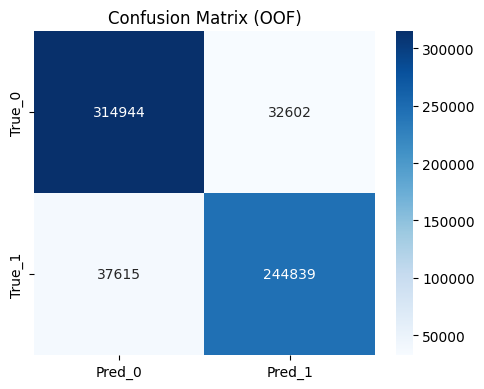

In [13]:
# Confusion matrix on OOF predictions of the best selected run
# Threshold-based view (complements threshold-free ROC-AUC)
CM_THRESHOLD = 0.5

if 'best_result' not in globals():
    raise RuntimeError('Run training and best-model selection cells first.')

y_true = y.values
y_prob = best_result['oof_pred']
y_pred = (y_prob >= CM_THRESHOLD).astype(int)

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['True_0', 'True_1'], columns=['Pred_0', 'Pred_1'])

print('Confusion Matrix (threshold =', CM_THRESHOLD, ')')
print(cm_df)
print()
print('Classification report:')
print(classification_report(y_true, y_pred, digits=4))

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (OOF)')
plt.tight_layout()
plt.show()

